# Theory for Atomic Fountain Interferometer - Beamsplitter

In [1]:
from functools import partial

In [2]:
import sympy
import numpy as np
import matplotlib
import matplotlib.pylab as plt

In [3]:
%matplotlib inline

In [4]:
sympy.init_printing()

In [5]:
from sympy import Wild, symbols, Function, exp, cos, I, DiracDelta, Abs, oo

In [6]:
from sympy import UnevaluatedExpr as protect

In [7]:
from symbolic_equation import Eq

In [8]:
# local imports
from dirac_tools import normalize_dirac_delta_terms

## Symbols

In [9]:
z, t, tc, k, Δ, μ12, p, p0, α, β = symbols('z, t, t_c, k, Delta, mu_12, p, p0, alpha, beta', real=True)

In [10]:
ω0, m, ħ, ωk, ωL = symbols('omega_0, m, hbar, omega_k, omega_L', positive=True)

In [11]:
a, b, b̃ = symbols('a, b, b̃', cls=Function)

In [12]:
δ0, δ0p = symbols("delta_0, delta_0^'", real=True)

In [13]:
ϕ1, ϕ2, ϕ3, ϕp, ϕm, ϕd, η = symbols("phi_1, phi_2, phi_3, phi_+, phi_-, phi_d, eta", cls=Function, real=True)

In [14]:
δ12, δ13, δ23 = symbols("delta12, delta_13, delta_23", cls=Function, real=True)

In [15]:
ω1, ω2, ω3, Enp, Enm = symbols("omega_1, omega_2, omega_3, E_n>0, E_n<0", cls=Function, real=True)

In [16]:
class _OmegaSym:
    def __getitem__(self, key):
        repl = {
            '-k^(+)': '+',
            '-k^(-)': '-',
        }
        key = repl.get(key, key)
        return symbols('Omega_%s' % key, cls=Function, positive=True)
Ω = _OmegaSym()

In [17]:
n, n0, nprime = symbols("n, n_0, n'", integer=True)

In [18]:
_w = Wild('w')

In [19]:
defs = {}

In [20]:
def definition(sym):
    return Eq(sym, defs[sym])

In [21]:
def standard_phase_form(expr):
    """Combine exponentials and separate out $i$ and $t$.
    This ensures the standard form $e^{i ω t)$
    """
    return (
        expr
        .powsimp()
        .replace(exp, lambda arg: exp(arg.collect(I)))
        .replace(exp, lambda arg: exp(arg.collect(t)))
    )

## Schrödinger equation in position space

**NOTE**: The original notes on the derivation of the Hamiltonian used a convention where the signs for the phases in $\Omega_{-}$ and $\Omega_{+}$ used opposite signs. Here, we have used a sign convention that leads to fully symmetric equations. The only things that changes is that any $\phi_3(t)$ and any $\delta_0^\prime$ change signs. Any lines that are affected by this are marked with a comment `# SIGN`.

In [22]:
defs[b̃(z, t)] = (
    1 / (2 * Δ) * (
        Ω['k'](t) * exp(-I * (ϕ1(t) + k*z))
        + Ω['-k^(+)'](t) * exp(-I * (ϕ2(t) + δ0 * t - k * z))
        + Ω['-k^(-)'](t) * exp(-I * (ϕ3(t) + δ0p * t - k * z))  # SIGN
    ) * a(z, t)
).expand().collect(a(z, t))

In [23]:
definition(b̃(z, t))

b̃(z, t) = (Omega_+(t)*exp(-I*phi_2(t))*exp(-I*delta_0*t)*exp(I*k*z)/(2*Delta) + Omega_-(t)*exp(-I*phi_3(t))*exp(-I*delta_0^'*t)*exp(I*k*z)/(2*Delta) + Omega_k(t)*exp(-I*phi_1(t))*exp(-I*k*z)/(2*Delta))*a(z, t)

In [24]:
TDSE_a = Eq(
    I * ħ * a(z, t).diff(t),
    p**2/(2*m) * a(z, t) - (
        Ω['k'](t) * cos(ω1(t) + k * z)
        + Ω['-k^(+)'](t) * cos(ω2(t) - k * z)
        + Ω['-k^(-)'](t) * cos(ω3(t) - k * z)
    ) * b(t)
)
TDSE_a

I*hbar*Derivative(a(z, t), t) = -(Omega_+(t)*cos(k*z - omega_2(t)) + Omega_-(t)*cos(k*z - omega_3(t)) + Omega_k(t)*cos(k*z + omega_1(t)))*b(t) + p**2*a(z, t)/(2*m)

In [25]:
TDSE_a_2 = (
    TDSE_a
    .apply_mtd(
        'subs',
        {
            b(t): defs[b̃(z, t)] * exp(-I * ω0 * t),
            ω1(t): ω0 * t + ϕ1(t),
            ω2(t): ω0 * t + ϕ2(t) + δ0 * t,
            ω3(t): ω0 * t + ϕ3(t) + δ0p * t,  # SIGN
        })
     .apply_mtd('rewrite', exp, cont=False)
     .apply_mtd('expand')
     .apply_mtd('subs', {exp(-2 * I * ω0 * t): 0}) # neglect counter-rotating term
     .apply(standard_phase_form)
     .apply_mtd('collect', a(z, t))
)
TDSE_a_2

I*hbar*Derivative(a(z, t), t) = (p**2/(2*m) - Omega_+(t)**2/(4*Delta) - Omega_+(t)*Omega_-(t)*exp(I*(t*(-delta_0 + delta_0^') - phi_2(t) + phi_3(t)))/(4*Delta) - Omega_+(t)*Omega_-(t)*exp(I*(t*(delta_0 - delta_0^') + phi_2(t) - phi_3(t)))/(4*Delta) - Omega_+(t)*Omega_k(t)*exp(I*(-delta_0*t + 2*k*z + phi_1(t) - phi_2(t)))/(4*Delta) - Omega_+(t)*Omega_k(t)*exp(I*(delta_0*t - 2*k*z - phi_1(t) + phi_2(t)))/(4*Delta) - Omega_-(t)**2/(4*Delta) - Omega_-(t)*Omega_k(t)*exp(I*(-delta_0^'*t + 2*k*z + phi_1(t) - phi_3(t)))/(4*Delta) - Omega_-(t)*Omega_k(t)*exp(I*(delta_0^'*t - 2*k*z - phi_1(t) + phi_3(t)))/(4*Delta) - Omega_k(t)**2/(4*Delta))*a(z, t)

## Introduce relative phases

In [26]:
defs.update({
    δ12(t): ϕ1(t) - ϕ2(t),
    δ13(t): ϕ1(t) - ϕ3(t),  # SIGN
    δ23(t): ϕ2(t) - ϕ3(t),  # SIGN
})

In [27]:
TDSE_a_3 = TDSE_a_2.apply_mtd('subs', {defs[sym]: sym for sym in [δ12(t), δ13(t), δ23(t)]})
TDSE_a_3

I*hbar*Derivative(a(z, t), t) = (p**2/(2*m) - Omega_+(t)**2/(4*Delta) - Omega_+(t)*Omega_-(t)*exp(I*(t*(-delta_0 + delta_0^') - delta_23(t)))/(4*Delta) - Omega_+(t)*Omega_-(t)*exp(I*(t*(delta_0 - delta_0^') + delta_23(t)))/(4*Delta) - Omega_+(t)*Omega_k(t)*exp(I*(-delta_0*t + 2*k*z + delta12(t)))/(4*Delta) - Omega_+(t)*Omega_k(t)*exp(I*(delta_0*t - 2*k*z - delta12(t)))/(4*Delta) - Omega_-(t)**2/(4*Delta) - Omega_-(t)*Omega_k(t)*exp(I*(-delta_0^'*t + 2*k*z + delta_13(t)))/(4*Delta) - Omega_-(t)*Omega_k(t)*exp(I*(delta_0^'*t - 2*k*z - delta_13(t)))/(4*Delta) - Omega_k(t)**2/(4*Delta))*a(z, t)

## Define common light shift and effective envelopes

In [28]:
defs.update(
    {
        Ω['Δ'](t): (
            (
                Ω['k'](t) ** 2
                + Ω['-k^(+)'](t) ** 2
                + Ω['-k^(-)'](t) ** 2
                + (
                    2
                    * Ω['-k^(+)'](t)
                    * Ω['-k^(-)'](t)
                    * cos(δ23(t) + (δ0 - δ0p) * t)  # SIGN
                )
            )
            / (4 * Δ)
        ).expand(),
        Ω['-eff'](t): ((Ω['k'](t) * Ω['-k^(-)'](t)) / (4 * Δ)),
        Ω['+eff'](t): ((Ω['k'](t) * Ω['-k^(+)'](t)) / (4 * Δ)),
        ϕp(t): δ13(t) - δ0p * t, # SIGN
        ϕm(t): δ12(t) - δ0 * t,
    }
)

In [29]:
definition(Ω['Δ'](t))

Omega_Δ(t) = Omega_+(t)**2/(4*Delta) + Omega_+(t)*Omega_-(t)*cos(delta_0*t - delta_0^'*t + delta_23(t))/(2*Delta) + Omega_-(t)**2/(4*Delta) + Omega_k(t)**2/(4*Delta)

In [30]:
definition(Ω['-eff'](t))

Omega_-eff(t) = Omega_-(t)*Omega_k(t)/(4*Delta)

In [31]:
definition(Ω['+eff'](t))

Omega_+eff(t) = Omega_+(t)*Omega_k(t)/(4*Delta)

In [32]:
definition(ϕp(t)).apply_mtd('subs', definition(δ13(t)).as_dict, cont=True)

phi_+(t) = -delta_0^'*t + delta_13(t)
         = -delta_0^'*t + phi_1(t) - phi_3(t)

In [33]:
definition(ϕm(t)).apply_mtd('subs', definition(δ12(t)).as_dict, cont=True)

phi_-(t) = -delta_0*t + delta12(t)
         = -delta_0*t + phi_1(t) - phi_2(t)

In [34]:
TDSE_a_4 = (
    TDSE_a_3.apply_mtd(
        'subs',
        {standard_phase_form(defs[Ω['Δ'](t)].rewrite('exp').expand()): Ω['Δ'](t)},
    )
    .apply_mtd(
        'subs',
        {defs[sym]: sym for sym in [Ω['-eff'](t), Ω['+eff'](t), ϕp(t), ϕm(t)]},
    )
    .apply_mtd('expand')
    .apply_mtd('collect', a(z, t))
    .apply_mtd('collect', exp(2 * I * k * z))
    .apply(standard_phase_form)
)
TDSE_a_4


I*hbar*Derivative(a(z, t), t) = ((-Omega_+eff(t)*exp(-I*phi_-(t)) - Omega_-eff(t)*exp(-I*phi_+(t)))*exp(-2*I*k*z) + (-Omega_+eff(t)*exp(I*phi_-(t)) - Omega_-eff(t)*exp(I*phi_+(t)))*exp(2*I*k*z) - Omega_Δ(t) + p**2/(2*m))*a(z, t)

## Transformation to momentum space

Mathematically, we take a Fourier transform:

\begin{align}
\int \textrm{d}z\, e^{-i \frac{p}{\hbar} z} a(z, t) &= a(p, t) \\
\int \textrm{d}z\, e^{-i \frac{p}{\hbar} z \pm i 2 k z} a(z, t) &= a(p\mp 2 \hbar k, t)
\end{align}

Thus, we can get the result of the Fourier transform by a simple substitution:

In [35]:
TDSE_mom = (TDSE_a_4
 .apply_mtd('expand')
 .apply_mtd('subs', {
     a(z,t) * exp(2*I*k*z): a(p - 2*ħ*k, t),  # note the sign!
     a(z,t) * exp(-2*I*k*z): a(p + 2*ħ*k, t)
 })
  .apply_mtd('subs', {
     a(z,t): a(p, t),
 })
 .apply(standard_phase_form)
 .apply_mtd('collect',  a(p + 2*ħ*k, t))
 .apply_mtd('collect',  a(p - 2*ħ*k, t))
 .apply_mtd('collect',  a(p, t))
)
TDSE_mom

I*hbar*Derivative(a(p, t), t) = (-Omega_+eff(t)*exp(-I*phi_-(t)) - Omega_-eff(t)*exp(-I*phi_+(t)))*a(2*hbar*k + p, t) + (-Omega_+eff(t)*exp(I*phi_-(t)) - Omega_-eff(t)*exp(I*phi_+(t)))*a(-2*hbar*k + p, t) + (-Omega_Δ(t) + p**2/(2*m))*a(p, t)

In [36]:
TDSE_mom = (TDSE_a_4
 .apply_mtd('expand')
 .apply_mtd('subs', {
     a(z,t) * exp(2*I*k*z): a(p + 2*ħ*k, t),  # note the sign!
     a(z,t) * exp(-2*I*k*z): a(p - 2*ħ*k, t)
 })
  .apply_mtd('subs', {
     a(z,t): a(p, t),
 })
 .apply(standard_phase_form)
 .apply_mtd('collect',  a(p + 2*ħ*k, t))
 .apply_mtd('collect',  a(p - 2*ħ*k, t))
 .apply_mtd('collect',  a(p, t))
)
TDSE_mom

I*hbar*Derivative(a(p, t), t) = (-Omega_+eff(t)*exp(-I*phi_-(t)) - Omega_-eff(t)*exp(-I*phi_+(t)))*a(-2*hbar*k + p, t) + (-Omega_+eff(t)*exp(I*phi_-(t)) - Omega_-eff(t)*exp(I*phi_+(t)))*a(2*hbar*k + p, t) + (-Omega_Δ(t) + p**2/(2*m))*a(p, t)

## Ansatz

The sum is explicit in the following

In [37]:
ansatz_positive = a(n, t) * DiracDelta(p-p0-2*n*ħ*k) * exp(I * n * ϕp(t))
ansatz_negative = a(n, t) * DiracDelta(p-p0-2*n*ħ*k) * exp(I * n * ϕm(t))

In [38]:
ansatz_positive

In [39]:
ansatz_negative

## Plug in the positive ansatz

In [40]:
TDSE_mom_pos = (
    TDSE_mom
    .apply_mtd('subs', {a(p, t): ansatz_positive})
    .apply_mtd('subs', {a(p - 2*ħ*k, t): ansatz_positive.subs({p:p - 2*ħ*k})})
    .apply_mtd('subs', {a(p + 2*ħ*k, t): ansatz_positive.subs({p:p + 2*ħ*k})})
    .apply_mtd_to_lhs('doit')  # apply the derivative (chain rule)
    .apply_mtd('expand')
    .apply_mtd('collect', DiracDelta(_w))
    .apply_mtd('collect', exp(_w))
    .apply(standard_phase_form)
    .apply_mtd('replace', DiracDelta, lambda arg: DiracDelta(arg.collect(2*ħ*k)))
    .apply(lambda term: normalize_dirac_delta_terms(term, target=(-2 * ħ * k * n + p - p0)))
)
TDSE_mom_pos

(-hbar*n*a(n, t)*Derivative(phi_+(t), t) + I*hbar*Derivative(a(n, t), t))*exp(I*n*phi_+(t))*DiracDelta(-2*hbar*k*n + p - p0) = (-Omega_Δ(t)*a(n, t) + p**2*a(n, t)/(2*m))*exp(I*n*phi_+(t))*DiracDelta(-2*hbar*k*n + p - p0) + (-Omega_+eff(t)*a(n - 1, t)*exp(I*((n - 1)*phi_+(t) - phi_-(t))) - Omega_-eff(t)*a(n - 1, t)*exp(I*((n - 1)*phi_+(t) - phi_+(t))))*DiracDelta(-2*hbar*k*n + p - p0) + (-Omega_+eff(t)*a(n + 1, t)*exp(I*((n + 1)*phi_+(t) + phi_-(t))) - Omega_-eff(t)*a(n + 1, t)*exp(I*((n + 1)*phi_+(t) + phi_+(t))))*DiracDelta(-2*hbar*k*n + p - p0)

### Integrate over momentum

In [41]:
TDSE_discrete_pos = (
    TDSE_mom_pos
    .apply(lambda side: sympy.Integral(side, (p, -oo, oo)).doit())
    .apply(lambda side: side * exp(-I * n * ϕp(t)))
    .apply_mtd('expand')
    .apply(lambda side: side + ħ * n * a(n, t) * ϕp(t).diff(t))
    .apply(standard_phase_form)
    .apply_mtd('collect', a(n-1, t))
    .apply_mtd('collect', a(n+1, t))
    .apply_mtd('collect', a(n, t))
)
TDSE_discrete_pos

I*hbar*Derivative(a(n, t), t) = (-Omega_+eff(t)*exp(I*(-phi_+(t) - phi_-(t))) - Omega_-eff(t)*exp(-2*I*phi_+(t)))*a(n - 1, t) + (-Omega_+eff(t)*exp(I*(phi_+(t) + phi_-(t))) - Omega_-eff(t)*exp(2*I*phi_+(t)))*a(n + 1, t) + (2*hbar**2*k**2*n**2/m + 2*hbar*k*n*p0/m + hbar*n*Derivative(phi_+(t), t) - Omega_Δ(t) + p0**2/(2*m))*a(n, t)

### Define p₀ and ωₖ

In [42]:
defs[ωk] = (2 * ħ * k**2) / m
definition(ωk)

omega_k = 2*hbar*k**2/m

**NOTE: this is the two-photon recoil frequency, different from $\omega_r = \omega_k/4$ as defined by Kovachy et al.**

In [43]:
TDSE_discrete_p0_pos = (
    TDSE_discrete_pos
    .apply_mtd('subs', {p0: β*2*ħ*k})
    .apply_mtd('subs', {defs[ωk]: ωk})
    .apply_mtd('subs', {ħ * ωk: protect(ħ * ωk)}) # keep ħωₖ together
    .apply_mtd('collect', n)
    .apply_mtd('collect', a(n-1, t))
    .apply_mtd('collect', a(n+1, t))
    .apply_mtd('collect', a(n, t))
)
TDSE_discrete_p0_pos

I*hbar*Derivative(a(n, t), t) = (-Omega_+eff(t)*exp(I*(-phi_+(t) - phi_-(t))) - Omega_-eff(t)*exp(-2*I*phi_+(t)))*a(n - 1, t) + (-Omega_+eff(t)*exp(I*(phi_+(t) + phi_-(t))) - Omega_-eff(t)*exp(2*I*phi_+(t)))*a(n + 1, t) + a(n, t)*(beta**2*(hbar*omega_k) + n**2*(hbar*omega_k) + n*(2*beta*(hbar*omega_k) + hbar*Derivative(phi_+(t), t)) - Omega_Δ(t))

In [44]:
pos_branch_phase = (defs[ϕp(t)] - defs[ϕm(t)]).subs({δ12(t): defs[δ12(t)], δ13(t): defs[δ13(t)]})
Eq(ϕp(t) - ϕm(t), pos_branch_phase)

phi_+(t) - phi_-(t) = delta_0*t - delta_0^'*t + phi_2(t) - phi_3(t)

### Use identical pulse envelopes

In [45]:
TDSE_discrete_p0_pos = (
    TDSE_discrete_p0_pos
    .apply_mtd('subs', {Ω['-eff'](t): Ω[''](t), Ω['+eff'](t): Ω[''](t)})
    .apply_mtd('collect', Ω[''](t))
)
TDSE_discrete_p0_pos

I*hbar*Derivative(a(n, t), t) = ((-exp(I*(-phi_+(t) - phi_-(t))) - exp(-2*I*phi_+(t)))*a(n - 1, t) + (-exp(I*(phi_+(t) + phi_-(t))) - exp(2*I*phi_+(t)))*a(n + 1, t))*Omega_(t) + a(n, t)*(beta**2*(hbar*omega_k) + n**2*(hbar*omega_k) + n*(2*beta*(hbar*omega_k) + hbar*Derivative(phi_+(t), t)) - Omega_Δ(t))

### Energy levels

In [46]:
Eq_Enp = Eq(Enp(t), TDSE_discrete_p0_pos.rhs.coeff(a(n,t)))
Eq_Enp

E_n>0(t) = beta**2*(hbar*omega_k) + n**2*(hbar*omega_k) + n*(2*beta*(hbar*omega_k) + hbar*Derivative(phi_+(t), t)) - Omega_Δ(t)

## Plug in the negative ansatz

In [47]:
TDSE_mom_neg = (
    TDSE_mom
    .apply_mtd('subs', {a(p, t): ansatz_negative})
    .apply_mtd('subs', {a(p - 2*ħ*k, t): ansatz_negative.subs({p:p - 2*ħ*k})})
    .apply_mtd('subs', {a(p + 2*ħ*k, t): ansatz_negative.subs({p:p + 2*ħ*k})})
    .apply_mtd_to_lhs('doit')    # apply the derivative (chain rule)
    .apply_mtd('expand')
    .apply_mtd('collect', DiracDelta(_w))
    .apply_mtd('collect', exp(_w))
    .apply(standard_phase_form)
    .apply_mtd('replace', DiracDelta, lambda arg: DiracDelta(arg.collect(2*ħ*k)))
    .apply(lambda term: normalize_dirac_delta_terms(term, target=(-2 * ħ * k * n + p - p0)))
)
TDSE_mom_neg

(-hbar*n*a(n, t)*Derivative(phi_-(t), t) + I*hbar*Derivative(a(n, t), t))*exp(I*n*phi_-(t))*DiracDelta(-2*hbar*k*n + p - p0) = (-Omega_Δ(t)*a(n, t) + p**2*a(n, t)/(2*m))*exp(I*n*phi_-(t))*DiracDelta(-2*hbar*k*n + p - p0) + (-Omega_+eff(t)*a(n - 1, t)*exp(I*((n - 1)*phi_-(t) - phi_-(t))) - Omega_-eff(t)*a(n - 1, t)*exp(I*((n - 1)*phi_-(t) - phi_+(t))))*DiracDelta(-2*hbar*k*n + p - p0) + (-Omega_+eff(t)*a(n + 1, t)*exp(I*((n + 1)*phi_-(t) + phi_-(t))) - Omega_-eff(t)*a(n + 1, t)*exp(I*((n + 1)*phi_-(t) + phi_+(t))))*DiracDelta(-2*hbar*k*n + p - p0)

### Integrate over momentum

In [48]:
TDSE_discrete_neg = (
    TDSE_mom_neg
    .apply(lambda side: sympy.Integral(side, (p, -oo, oo)).doit())
    .apply(lambda side: side * exp(-I * n * ϕm(t)))  # using ϕ₋(t) instead of ϕ₊(t)
    .apply_mtd('expand')
    .apply(lambda side: side + ħ * n * a(n, t) * ϕm(t).diff(t))  # using ϕ₋(t) instead of ϕ₊(t)
    .apply(standard_phase_form)
    .apply_mtd('collect', a(n-1, t))
    .apply_mtd('collect', a(n+1, t))
    .apply_mtd('collect', a(n, t))
)
TDSE_discrete_neg

I*hbar*Derivative(a(n, t), t) = (-Omega_+eff(t)*exp(-2*I*phi_-(t)) - Omega_-eff(t)*exp(I*(-phi_+(t) - phi_-(t))))*a(n - 1, t) + (-Omega_+eff(t)*exp(2*I*phi_-(t)) - Omega_-eff(t)*exp(I*(phi_+(t) + phi_-(t))))*a(n + 1, t) + (2*hbar**2*k**2*n**2/m + 2*hbar*k*n*p0/m + hbar*n*Derivative(phi_-(t), t) - Omega_Δ(t) + p0**2/(2*m))*a(n, t)

### Define p₀ and ωₖ

In [49]:
TDSE_discrete_p0_neg = (
    TDSE_discrete_neg
    .apply_mtd('subs', {p0: β*2*ħ*k})
    .apply_mtd('subs', {defs[ωk]: ωk})
    .apply_mtd('subs', {ħ * ωk: protect(ħ * ωk)})
    .apply_mtd('collect', n)
    .apply_mtd('collect', a(n-1, t))
    .apply_mtd('collect', a(n+1, t))
    .apply_mtd('collect', a(n, t))
)
TDSE_discrete_p0_neg

I*hbar*Derivative(a(n, t), t) = (-Omega_+eff(t)*exp(-2*I*phi_-(t)) - Omega_-eff(t)*exp(I*(-phi_+(t) - phi_-(t))))*a(n - 1, t) + (-Omega_+eff(t)*exp(2*I*phi_-(t)) - Omega_-eff(t)*exp(I*(phi_+(t) + phi_-(t))))*a(n + 1, t) + a(n, t)*(beta**2*(hbar*omega_k) + n**2*(hbar*omega_k) + n*(2*beta*(hbar*omega_k) + hbar*Derivative(phi_-(t), t)) - Omega_Δ(t))

### Use identical pulse envelopes

In [50]:
TDSE_discrete_p0_neg = (
    TDSE_discrete_p0_neg
    .apply_mtd('subs', {Ω['-eff'](t): Ω[''](t), Ω['+eff'](t): Ω[''](t)})
    .apply_mtd('collect', Ω[''](t))
)
TDSE_discrete_p0_neg

I*hbar*Derivative(a(n, t), t) = ((-exp(I*(-phi_+(t) - phi_-(t))) - exp(-2*I*phi_-(t)))*a(n - 1, t) + (-exp(I*(phi_+(t) + phi_-(t))) - exp(2*I*phi_-(t)))*a(n + 1, t))*Omega_(t) + a(n, t)*(beta**2*(hbar*omega_k) + n**2*(hbar*omega_k) + n*(2*beta*(hbar*omega_k) + hbar*Derivative(phi_-(t), t)) - Omega_Δ(t))

### Energy levels

In [51]:
Eq_Enm = Eq(Enm(t), TDSE_discrete_p0_neg.rhs.coeff(a(n,t)))
Eq_Enm

E_n<0(t) = beta**2*(hbar*omega_k) + n**2*(hbar*omega_k) + n*(2*beta*(hbar*omega_k) + hbar*Derivative(phi_-(t), t)) - Omega_Δ(t)

As expected, we get the same equation, just with $\phi_{-}(t)$ instead of $\phi_{+}(t)$.

## Rapid adiabatic passage

In [52]:
definition(ϕm(t)).apply_mtd('subs', {δ12(t): defs[δ12(t)]}, cont=True)

phi_-(t) = -delta_0*t + delta12(t)
         = -delta_0*t + phi_1(t) - phi_2(t)

In [53]:
definition(ϕp(t)).apply_mtd('subs', {δ13(t): defs[δ13(t)]}, cont=True)

phi_+(t) = -delta_0^'*t + delta_13(t)
         = -delta_0^'*t + phi_1(t) - phi_3(t)

In [54]:
rap_phases = {
    ϕp(t): α * protect(t - tc)**2 / 2,
    ϕm(t): -α * protect(t - tc)**2 / 2,
}

In [55]:
def plug_in_phases(phases_dict):
    def _doit(expr):
        expr_expanded = standard_phase_form(
            expr
            .subs(phases_dict)
            .doit()  # do the derivatives
            .expand()
        )
        return (
            expr_expanded
            .collect(a(n-1, t))
            .collect(a(n+1, t))
            .collect(a(n, t))
        )
    return _doit

In [56]:
def rap_rewriting(expr):
    """Write things a bit more intuitively, specifically for the RAP case"""
    return (
        expr
        .subs({(α * (t - tc)**2).expand(): (α * (t - tc)**2)})
        .subs({(α * ħ * n * (t - tc)).expand(): n * protect(ħ*α * (t - tc))})
        .subs({tc - t: sympy.Mul(-1, protect(t - tc), evaluate=False)})
        .subs({ħ * ωk: protect(ħ * ωk)})
        .collect((t-tc))
    )

In [57]:
TDSE_rap_pos = (
    TDSE_discrete_p0_pos
    .apply(plug_in_phases(rap_phases))
    .apply(rap_rewriting)
)
TDSE_rap_pos

I*hbar*Derivative(a(n, t), t) = a(n, t)*(beta**2*(hbar*omega_k) + 2*beta*n*(hbar*omega_k) + n**2*(hbar*omega_k) + n*(alpha*hbar*(t - t_c)) - Omega_Δ(t)) + a(n - 1, t)*(-Omega_(t) - Omega_(t)*exp(-I*alpha*(t - t_c)**2)) + a(n + 1, t)*(-Omega_(t) - Omega_(t)*exp(I*alpha*(t - t_c)**2))

In [58]:
TDSE_rap_neg = (
    TDSE_discrete_p0_neg
    .apply(plug_in_phases(rap_phases))
    .apply(rap_rewriting)
    .apply_mtd('subs', {-n: Abs(n)})
)
TDSE_rap_neg

I*hbar*Derivative(a(n, t), t) = a(n, t)*(beta**2*(hbar*omega_k) + 2*beta*n*(hbar*omega_k) + n**2*(hbar*omega_k) - Omega_Δ(t) + Abs(n)*(alpha*hbar*(t - t_c))) + a(n - 1, t)*(-Omega_(t) - Omega_(t)*exp(I*alpha*(t - t_c)**2)) + a(n + 1, t)*(-Omega_(t) - Omega_(t)*exp(-I*alpha*(t - t_c)**2))

## Dynamic Frame

In [59]:
defs[η(t)] = -protect((α * (t - tc))**2 + 1) / 4
definition(η(t))

eta(t) = -(alpha**2*(t - t_c)**2 + 1)/4

In [60]:
defs[ϕd(t)] = sympy.Integral(defs[η(t)], t)
definition(ϕd(t)).apply_mtd('doit', cont=True)

phi_d(t) = Integral(-(alpha**2*(t - t_c)**2 + 1)/4, t)
         = -alpha**2*t**3/12 + alpha**2*t**2*t_c/4 + t*(-alpha**2*t_c**2/4 - 1/4)

In [61]:
def to_dynamic_frame(H, U):
    return (
        I*ħ*U.diff(t).doit()*U.conjugate().transpose().doit()
        + (U * H * U.conjugate().transpose()).doit()
    )

In [62]:
Eq(Enp(t), to_dynamic_frame(
    H=TDSE_rap_pos.rhs.coeff(a(n, t)).subs({β: 0, Ω['Δ'](t): 0}),
    U=exp(I * sympy.Integral(defs[η(t)], t))
))

E_n>0(t) = alpha*hbar*n*(t - t_c) + hbar*n**2*omega_k + hbar*(alpha**2*(t - t_c)**2 + 1)/4

## Scheme with π pulses

We choose a laser frequency that targets the transition $n_0 \rightarrow n_0+1$

In [63]:
defs[ωL] = (((n0+1)**2 - n0**2) * ωk).expand().collect(ωk)
definition(ωL)

omega_L = omega_k*(2*n_0 + 1)

In [64]:
defs[nprime] = Abs(n) - n0
definition(nprime)

n' = -n_0 + Abs(n)

In [65]:
pipulse_phases = {
    ϕp(t): (-ωL * t).subs(definition(ωL).as_dict),
    ϕm(t): (ωL * t).subs(definition(ωL).as_dict),
}

In [66]:
pipulse_phases

In [67]:
def rewrite_with_nprime(abs_n=None):
    E_n = ((nprime**2 - nprime) - (n0 * (n0+1))) * protect(ħ*ωk)
    E_n_expanded = (
        E_n
        .subs(definition(nprime).as_dict)
        .expand()
        .doit() # un-protect ħωₖ
    )
    if abs_n is not None:
        E_n_expanded = E_n_expanded.subs({Abs(n): abs_n})
        
    def _doit(expr):
        return expr.subs({E_n_expanded: E_n})
    
    return _doit        

In [68]:
TDSE_pipulse_pos = (
    TDSE_discrete_p0_pos
    .apply(plug_in_phases(pipulse_phases))
    .apply(rewrite_with_nprime(abs_n=n))
)
TDSE_pipulse_pos

I*hbar*Derivative(a(n, t), t) = (-Omega_(t)*exp(I*t*(-4*n_0*omega_k - 2*omega_k)) - Omega_(t))*a(n + 1, t) + (-Omega_(t)*exp(I*t*(4*n_0*omega_k + 2*omega_k)) - Omega_(t))*a(n - 1, t) + a(n, t)*(beta**2*hbar*omega_k + 2*beta*hbar*n*omega_k + (n'**2 - n' - n_0*(n_0 + 1))*(hbar*omega_k) - Omega_Δ(t))

In [69]:
TDSE_pipulse_neg = (
    TDSE_discrete_p0_neg
    .apply(plug_in_phases(pipulse_phases))
    .apply(rewrite_with_nprime(abs_n=-n))
)
TDSE_pipulse_neg

I*hbar*Derivative(a(n, t), t) = (-Omega_(t)*exp(I*t*(-4*n_0*omega_k - 2*omega_k)) - Omega_(t))*a(n - 1, t) + (-Omega_(t)*exp(I*t*(4*n_0*omega_k + 2*omega_k)) - Omega_(t))*a(n + 1, t) + a(n, t)*(beta**2*hbar*omega_k + 2*beta*hbar*n*omega_k + (n'**2 - n' - n_0*(n_0 + 1))*(hbar*omega_k) - Omega_Δ(t))

### Effective pulse amplitude

In [70]:
effective_pi_amplitude = TDSE_pipulse_neg.rhs.coeff(a(n+1, t)).coeff(Ω[''](t)).subs({ωk: 1})
effective_pi_amplitude

In [71]:
def plot_effective_amplitude(n0_val, tlist):
    y = np.abs([complex(effective_pi_amplitude.subs({t: tval, n0: n0_val})) for tval in tlist])
    fig, ax = plt.subplots()
    ax.plot(tlist, y)
    plt.show(fig)
    print("average: %.2f" % np.average(y))

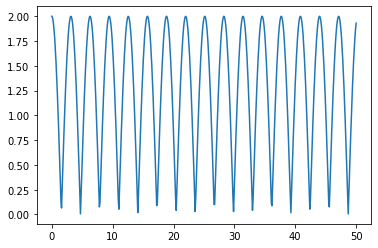

average: 1.27


In [72]:
plot_effective_amplitude(0, np.linspace(0, 50, 500))

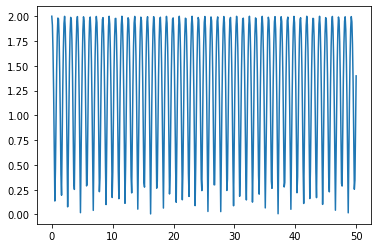

average: 1.27


In [73]:
plot_effective_amplitude(1, np.linspace(0, 50, 500))

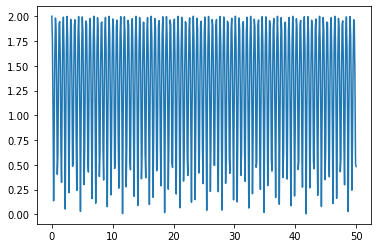

average: 1.27


In [74]:
plot_effective_amplitude(2, np.linspace(0, 50, 500))